Initialized explainer with map size (100, 120)
[    0     1     1     1     1     1     2     2     2     2     2     3
     3     3     3     4     4     5     5     6     6     7     7     8
     9    10    11    12    13    14    16    17    19    21    23    25
    28    30    33    37    40    44    49    54    59    65    71    79
    86    95   104   115   126   139   153   168   185   203   223   245
   270   297   326   359   394   434   477   524   576   634   697   766
   842   926  1018  1120  1231  1354  1488  1636  1799  1978  2175  2392
  2630  2892  3179  3496  3844  4226  4647  5109  5618  6177  6791  7467
  8210  9028  9926 10914 12000]


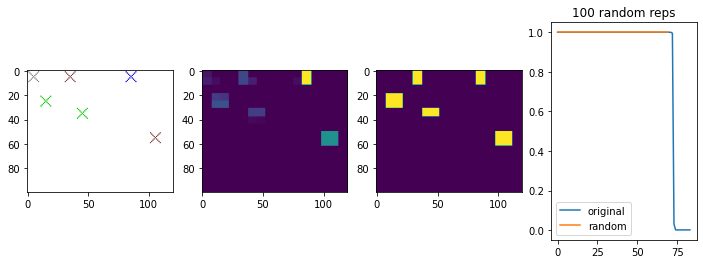

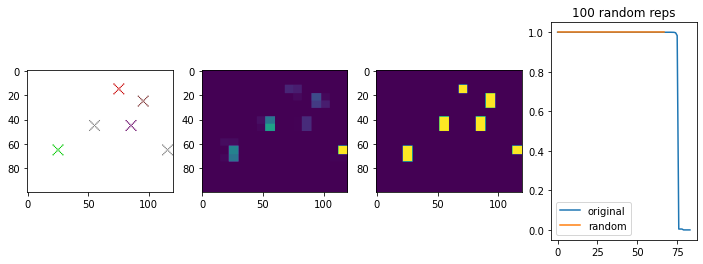

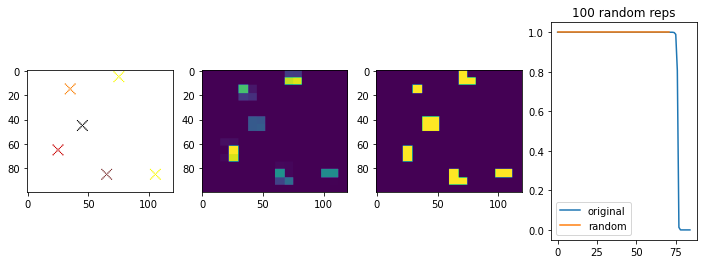

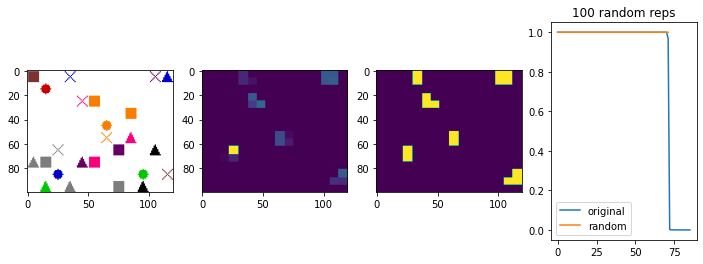

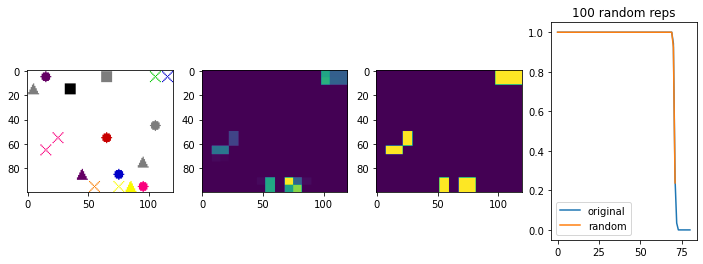

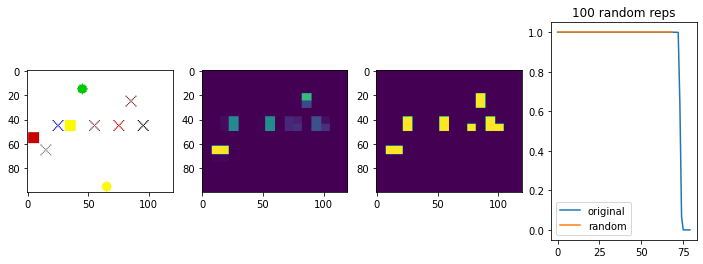

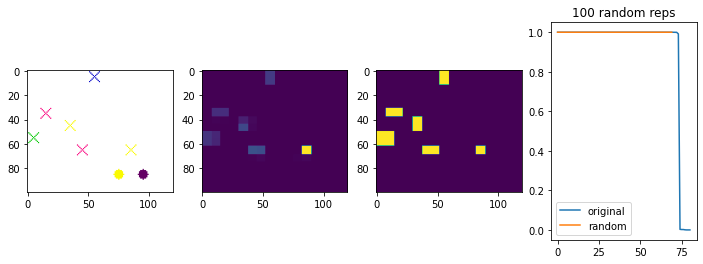

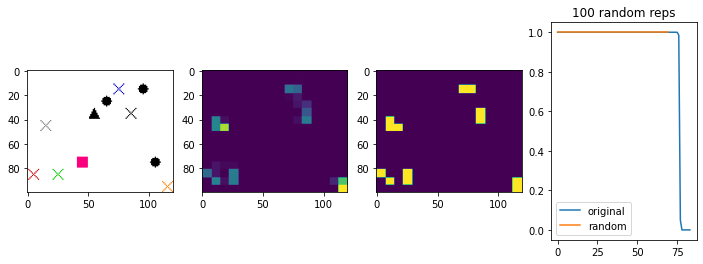

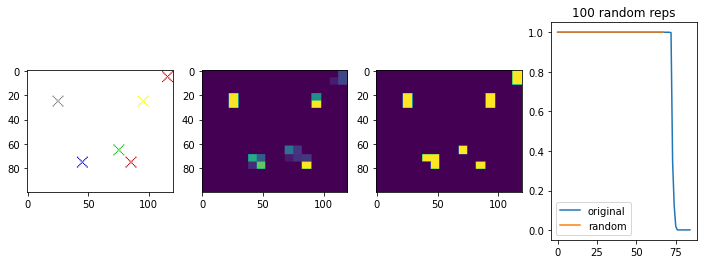

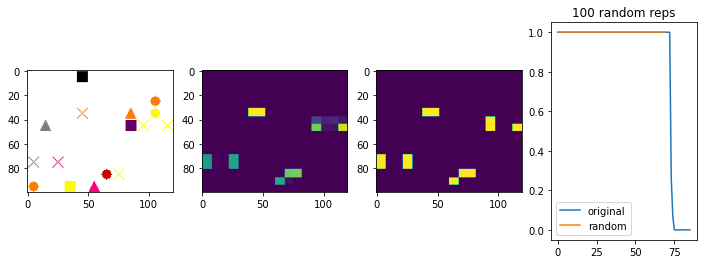

In [4]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
import time
import pandas as pd
import matplotlib.patches as patches
import hshap
from net import Net
import shap
from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp
from RDE.ComputeExplainability import generate_explainability_map 
from lime import lime_image

os.environ["CUDA_VISIBLE_DEVICES"]="5"

device = torch.device("cuda:0")
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

torch.manual_seed(0)
model = Net()
weight_path = "model2.pth"
model.load_state_dict(torch.load(weight_path, map_location=device)) 
model.to(device)
model.eval()


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])


data_dir = "/export/gaon1/data/jteneggi/data/synthetic/datasets"
train_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), transform)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=0)
_iter = iter(dataloader)
X, _ = next(_iter)
ref = X.detach().mean(0)
ref = ref.to(device)
hexp = hshap.src.Explainer(model, ref)

def hexp_explain(hexp, image_t):
    (explanation, _) = hexp.explain(image_t, label=1, minW=5, minH=5, threshold_mode=threshold_mode, percentile=percentile, threshold=threshold)
    return explanation

c = [6]
true_positives = np.load("true_positives.npy", allow_pickle=True).item()

A = 100*120
exp_x = np.linspace(np.log10(1/A), 0, 100)
relative_perturbation_sizes = np.concatenate(([0], np.sort(10 ** (exp_x))))
perturbation_sizes = np.round(A * relative_perturbation_sizes)
perturbation_sizes = np.array(perturbation_sizes, dtype="int")
print(perturbation_sizes)
perturbations_L = len(perturbation_sizes)

explainer = hexp
explain = hexp_explain

for n in c:
    for i, image_path in enumerate(true_positives[str(n)][:10]):
        image_name = os.path.basename(image_path)
        image = Image.open(image_path)
        image_RGB = image.convert("RGB")
        image_t = transform(image)
        threshold_mode = "absolute"
        threshold = 0
        percentile = 0
        explanation = explain(explainer, image_t)
        torch.cuda.empty_cache()
        
        fig = plt.figure(figsize=(12, 4))
        axes = fig.subplots(1, 4)
        
        ax = axes[0]
        ax.imshow(image)
        
        ax = axes[1]
        ax.imshow(explanation)
        
        ax = axes[2]
        binary_explanation = (explanation > 2e-2).astype(float)
        ax.imshow(binary_explanation)
        
        tmp = hshap.utils.compute_perturbed_logits(model, ref, image_t.to(device).detach(), explanation, perturbation_sizes, normalization="original")
        ax = axes[3]
        ax.plot(tmp, label="original")
        
        reps = 100
        t = []
        for rep in np.arange(reps):
            t.append(hshap.utils.compute_perturbed_logits(model, ref, image_t.to(device).detach(), binary_explanation, perturbation_sizes, normalization="original", random_sampling=True))
            ax = axes[3]
        mu = np.mean(t, axis=0)
        ax.plot(mu, label="random")
        
        ax.set_title("100 random reps")
        
        ax.legend()
        
        plt.show()